# DSA2040A OLAP Assignment  
**Student:** Abdiqalaq Issack -243  
**Institution:** USIU-Africa  

This notebook demonstrates the implementation of a **mini OLAP system** using SQLite + Pandas in Jupyter Notebook.  
The goal is to show understanding of **ROLAP, MOLAP, and HOLAP architectures** as well as OLAP operations:  
**Slice, Dice, Roll-Up, and Drill-Down.**

---


In [27]:
# 1. Setup
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# Database connection
def create_connection(db_file="sales_demo.db"):
    return sqlite3.connect(db_file)

conn = create_connection()


## 2. Data Warehouse Design (Star Schema)

We will create one **Fact Table** and two **Dimension Tables**.

**Fact Table: sales**
- sale_id (int, PK)
- date (str, FK)
- product_id (int, FK)
- quantity (int)
- revenue (float)

**Dimension Tables:**
- products (product_id, category, name, price)  
- dates (date, year, quarter, month)  

---


In [28]:
# Create sample data
products = pd.DataFrame({
    'product_id': [1,2,3,4],
    'category': ['Electronics','Electronics','Clothing','Clothing'],
    'name': ['Laptop','Phone','Shirt','Shoes'],
    'price': [1000,500,50,80]
})

dates = pd.DataFrame({
    'date': ['2024-01-10','2024-02-15','2024-03-05','2024-04-20','2024-06-10'],
    'year': [2024,2024,2024,2024,2024],
    'quarter': ['Q1','Q1','Q1','Q2','Q2'],
    'month': ['Jan','Feb','Mar','Apr','Jun']
})

sales = pd.DataFrame({
    'sale_id': [1,2,3,4,5],
    'date': ['2024-01-10','2024-02-15','2024-03-05','2024-04-20','2024-06-10'],
    'product_id': [1,2,3,4,2],
    'quantity': [2,5,10,3,4],
    'revenue': [2000,2500,500,240,2000]
})

# Load into SQLite
products.to_sql('products', conn, if_exists='replace', index=False)
dates.to_sql('dates', conn, if_exists='replace', index=False)
sales.to_sql('sales', conn, if_exists='replace', index=False)

print("Tables created: products, dates, sales")


Tables created: products, dates, sales


## 3. OLAP Implementations
### (a) ROLAP (Relational OLAP using SQL)
We will run SQL queries directly on SQLite to get OLAP-style aggregations:
1. Average revenue by product category  
2. Total sales by year  
3. Best-selling product in each category  


In [29]:
# Query 1: Average revenue by category
q1 = """
SELECT p.category, AVG(s.revenue) as avg_revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category;
"""
rolap1 = pd.read_sql_query(q1, conn)
print("ROLAP: Average Revenue by Category")
print(rolap1)

# Query 2: Total sales by year
q2 = """
SELECT d.year, SUM(s.revenue) as total_revenue
FROM sales s
JOIN dates d ON s.date = d.date
GROUP BY d.year;
"""
rolap2 = pd.read_sql_query(q2, conn)
print("\nROLAP: Total Revenue by Year")
print(rolap2)

# Query 3: Best selling product in each category
q3 = """
SELECT p.category, p.name, SUM(s.quantity) as total_sold
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category, p.name
ORDER BY total_sold DESC;
"""
rolap3 = pd.read_sql_query(q3, conn)
print("\nROLAP: Best-Selling Products")
print(rolap3)


ROLAP: Average Revenue by Category
      category  avg_revenue
0     Clothing   370.000000
1  Electronics  2166.666667

ROLAP: Total Revenue by Year
   year  total_revenue
0  2024           7240

ROLAP: Best-Selling Products
      category    name  total_sold
0     Clothing   Shirt          10
1  Electronics   Phone           9
2     Clothing   Shoes           3
3  Electronics  Laptop           2


### (b) MOLAP (Multidimensional OLAP using Pandas)

We use Pandas pivot tables to build OLAP cubes.  
Here, we aggregate **Revenue by Product Category × Year**.


MOLAP Cube (Category × Year):
year         2024
category         
Clothing      740
Electronics  6500


/var/folders/kf/ycsk6hwn7zg_vr2g3zgr78bw0000gn/T/ipykernel_51137/3237028681.py:1: FutureWarning: The provided callable <function sum at 0x1188b6f20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cube = pd.pivot_table(


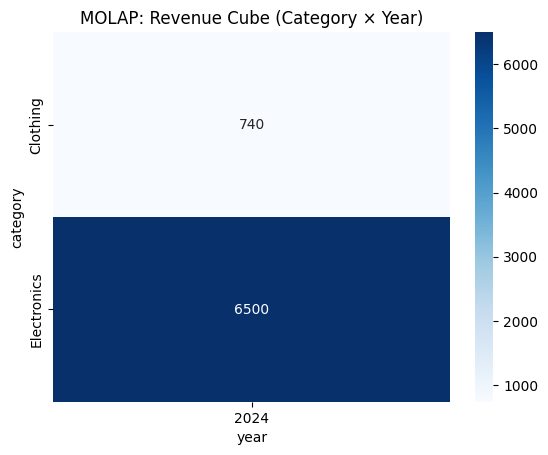

In [30]:
cube = pd.pivot_table(
    sales.merge(products, on="product_id").merge(dates, on="date"),
    values="revenue",
    index="category",
    columns="year",
    aggfunc=np.sum,
    fill_value=0
)
print("MOLAP Cube (Category × Year):")
print(cube)

# Heatmap visualization
sns.heatmap(cube, annot=True, fmt=".0f", cmap="Blues")
plt.title("MOLAP: Revenue Cube (Category × Year)")
plt.show()


### (c) HOLAP (Hybrid OLAP)

We combine **ROLAP for details** and **MOLAP for summaries**.


HOLAP Summary (Avg Revenue by Category):
      category      revenue
0     Clothing   370.000000
1  Electronics  2166.666667


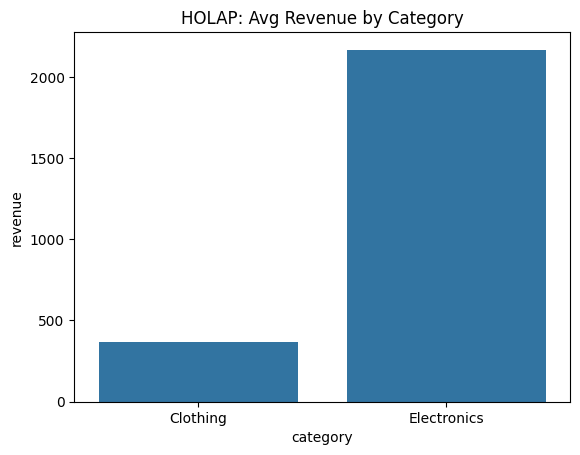

In [31]:
# Detailed data (ROLAP)
detail_sql = """
SELECT s.sale_id, p.category, p.name, d.year, d.quarter, s.quantity, s.revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date;
"""
detail_df = pd.read_sql_query(detail_sql, conn)

# MOLAP summary
holap_summary = detail_df.groupby("category")["revenue"].mean().reset_index()
print("HOLAP Summary (Avg Revenue by Category):")
print(holap_summary)

# Visualization
sns.barplot(data=holap_summary, x="category", y="revenue")
plt.title("HOLAP: Avg Revenue by Category")
plt.show()


## 4. OLAP Operations
We now demonstrate **Slice, Dice, Roll-Up, and Drill-Down**.


Slice (Q1 2024 Sales):
   sale_id     category    name  year quarter  quantity  revenue
0        1  Electronics  Laptop  2024      Q1         2     2000
1        2  Electronics   Phone  2024      Q1         5     2500
2        3     Clothing   Shirt  2024      Q1        10      500

Dice (Electronics in Q1 2024):
   sale_id     category    name  year quarter  quantity  revenue
0        1  Electronics  Laptop  2024      Q1         2     2000
1        2  Electronics   Phone  2024      Q1         5     2500

Roll-Up (Revenue by Category and Year):
      category  year  revenue
0     Clothing  2024      740
1  Electronics  2024     6500

Drill-Down (Revenue by Year and Quarter):
   year quarter  revenue
0  2024      Q1     5000
1  2024      Q2     2240


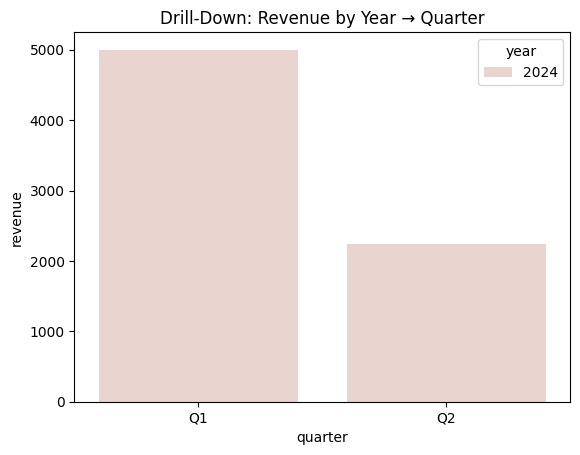

In [32]:
# Slice: Sales in Q1 2024
slice_df = detail_df[detail_df['quarter']=='Q1']
print("Slice (Q1 2024 Sales):")
print(slice_df)

# Dice: Electronics in Q1 2024
dice_df = detail_df[(detail_df['quarter']=='Q1') & (detail_df['category']=='Electronics')]
print("\nDice (Electronics in Q1 2024):")
print(dice_df)

# Roll-Up: From Product → Category → Year
rollup = detail_df.groupby(['category','year'])['revenue'].sum().reset_index()
print("\nRoll-Up (Revenue by Category and Year):")
print(rollup)

# Drill-Down: From Year → Quarter
drill = detail_df.groupby(['year','quarter'])['revenue'].sum().reset_index()
print("\nDrill-Down (Revenue by Year and Quarter):")
print(drill)

# Visualization
sns.barplot(data=drill, x="quarter", y="revenue", hue="year")
plt.title("Drill-Down: Revenue by Year → Quarter")
plt.show()


## 5. Visualization Results
- **ROLAP**: Bar plots of revenue by category and by year.  
- **MOLAP**: Heatmap of revenue by category × year.  
- **HOLAP**: Bar plot of average revenue by category.  
- **Drill-Down**: Revenue trends by year → quarter.  

These visualizations confirm the ability of OLAP to provide insights across multiple dimensions.


## ✅ Conclusion
This notebook demonstrated a **mini OLAP system** using:
- **ROLAP** with SQLite SQL queries  
- **MOLAP** with Pandas pivot tables  
- **HOLAP** combining both  
- OLAP Operations: **Slice, Dice, Roll-Up, Drill-Down**  
- Visualizations for better interpretation  

This assignment showed how OLAP can be implemented in a lightweight environment (SQLite + Pandas) to analyze multidimensional data.

**Author:** Abdiqalaq Issack -243  
